# Text and Graph Mining proof-of-concept product

The goal of this notebook is to categorize the reviews about resturants in Jordan to positive (1), negative (2) and neutral (0) reviews.

## 1- Data Analysis & Preprocessing.

In [1]:
# Importing necessary libraries
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from collections import Counter
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
# Importing the dataset
df = pd.read_csv("reviews.csv", encoding= 'utf-8')
df.head(5)

,Text,Class
0,المكان كتيير حلو اكله الحمدلله منيح عادي وفي ا...,1
1,المطعم زرته ﻷول مرة مبارح على بوفيه الفطور الر...,1
2,سناكاته زاكية سعره سعر السوق ..احلى ما في المو...,1
3,"بهارات البروستد كتير مميزة ومش ناقصها اشي , وا...",1
4,هاد الفرع مش تابع لشاورما الريم الاصلي فروع شا...,0


In [3]:
# Checking the size of the data 
df.shape

(2500, 2)

The data consists of 2 features and 2500 instances.

In [4]:
# Checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2500 non-null   object
 1   Class   2500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.2+ KB


As can be noticed, the text is an object while the classes are numerical.

In [5]:
# Checking for nulls
df.isnull().sum()

Text     0
Class    0
dtype: int64

The data has no null values

In [6]:
# Checking and droping duplicates
df.drop_duplicates(inplace = True)
df.shape

(2481, 2)

The size of instances changed from 2500 to 2481, meaning that there were 19 duplicates in the data.

In [7]:
# Checking the classes' unique values
df['Class'].unique()

array([1, 0, 2])

In [8]:
# Checking the balance of classes
df['Class'].value_counts()

1    1884
2     347
0     250
Name: Class, dtype: int64

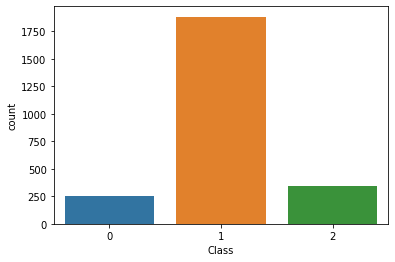

In [9]:
# Plotting the distribution of classes among the instances
sns.countplot(x = 'Class', data = df)
plt.show()

As can be seen from the above, the classes are not balanced, this issue will be handeled after the data is transformed to structured form.

In [10]:
# Creating a function to clean arabic text data from any punctutation, tashkeel, longation, 
# repeating characters, numbers special characters and emojis
import string
from string import digits

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def clean_feedback(feedback):

    # Removing punctuations
    translator = str.maketrans('', '', punctuations_list)
    text1 = feedback.translate(translator)

    # Removing longation
    text1 = re.sub("[إأآا]", "ا", text1)
    text1 = re.sub("ى", "ي", text1)
    text1 = re.sub("ؤ", "ء", text1)
    text1 = re.sub("ئ", "ء", text1)
    text1 = re.sub("ة", "ه", text1)
    text1 = re.sub("گ", "ك", text1)
    # print(text1)

    # Removing special characters 
    text1 = re.sub("@[ا-ي0-9]+", " ", text1)
    text1 = re.sub("[أ-ي]#+", " ", text1)
    text1 = re.sub("#[أ-ي]+", " ", text1)
    # print(text1)

    # Removing Tashkeel
    text1 = re.sub(arabic_diacritics, '', text1)

    # Removing emojies
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text1 = re.sub(emoj, '', text1)

    # Removing numbers
    text1 = ''.join(filter(lambda x: not x.isdigit(), text1))

    # Removing repeating charecters
    text1 = re.sub(r'(.)\1+', r'\1', text1)

    text2 = ''.join([w for w in text1])
    return text2

### Text cleaning.

In [11]:
# Applying the cleaning function on the text
df['Text'] = df['Text'].apply(clean_feedback)
df.head(5)

,Text,Class
0,المكان كتير حلو اكله الحمدله منيح عادي وفي اشي...,1
1,المطعم زرته ول مره مبارح علي بوفيه الفطور الرم...,1
2,سناكاته زاكيه سعره سعر السوق احلي ما في الموضو...,1
3,بهارات البروستد كتير ميزه ومش ناقصها اشي والاك...,1
4,هاد الفرع مش تابع لشاورما الريم الاصلي فروع شا...,0


In [12]:
# Checking one sentence
df['Text'][72]

'اجمل محل خدمه سريعه يعني انجد يعطيهم العافيه شباب القاعده بجن '

### Text tokenization.

In [13]:
# Tokenization (splitting each instance from a sentence into words)
df['Text'] = df['Text'].apply(word_tokenize)
df.head(5)

,Text,Class
0,"[المكان, كتير, حلو, اكله, الحمدله, منيح, عادي,...",1
1,"[المطعم, زرته, ول, مره, مبارح, علي, بوفيه, الف...",1
2,"[سناكاته, زاكيه, سعره, سعر, السوق, احلي, ما, ف...",1
3,"[بهارات, البروستد, كتير, ميزه, ومش, ناقصها, اش...",1
4,"[هاد, الفرع, مش, تابع, لشاورما, الريم, الاصلي,...",0


### Stop words removal from text.

In [14]:
# Removing stop words (words that will not affect the categorizatio of the reviews)
stop_words = set(stopwords.words('arabic'))
df['Text'] = df['Text'].apply(lambda x: " ".join(i for i in x if i not in stop_words))
df.head(5)

,Text,Class
0,المكان كتير حلو اكله الحمدله منيح عادي وفي اشي...,1
1,المطعم زرته ول مره مبارح علي بوفيه الفطور الرم...,1
2,سناكاته زاكيه سعره سعر السوق احلي الموضوع انه ...,1
3,بهارات البروستد كتير ميزه ومش ناقصها اشي والاك...,1
4,هاد الفرع مش تابع لشاورما الريم الاصلي فروع شا...,0


### Text stemming.

In [15]:
# Applying Stemming (returning words to their roots)
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("arabic")
df['Text'] = df['Text'].apply(lambda x: ' '.join([stemmer.stem(y) for y in x.split()]))
df.head(5)

,Text,Class
0,المك كتير حلو اكل حمدله منيح عاد وف اش كان طيب,1
1,مطعم زرت ول مره مبارح عل بوف فطور رمضان المك ن...,1
2,سناك زاك سعر سعر سوق احل موضوع انه خدم توصيل,1
3,هار بروستد كتير ميز ومش ناقص اش اكل مستو منيح ...,1
4,هاد فرع مش تابع شاورم ريم اصل روع شاورم ريم مع...,0


## 2- Feature extraction from text.

In [16]:
# Storing the text column from the dataset into a list
text_list = df['Text'].tolist()
text_list[0]

'المك كتير حلو اكل حمدله منيح عاد وف اش كان طيب'

In [17]:
# Storing the class column from the dataset into a list
counter = Counter(df['Class'].tolist())
top_10_varieties = {i[0]: idx for idx, i in enumerate(counter.most_common())}
df[df['Class'].map(lambda x: x in top_10_varieties)]
varietal_list = [top_10_varieties[i] for i in df['Class'].tolist()]
varietal_list = np.array(varietal_list)
print(varietal_list)

[0 0 0 ... 0 0 2]


In [18]:
# Applying CountVectorizer to text data
# CountVectorizer creates a matrix in which each unique word is represented by  a column of the matrix,
# and each text sample from the document is a row in the matrix.
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(text_list)

In [19]:
# Calculating tf-idf to text data 
# It can be defined as the calculation of how relevant a word in a series or corpus is to a text.
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

### Classes over sampling

As seen in the preprocessing section, the classes were imbalanced, now after text data is transformed into structured data, it can be balanced by usin the below oversampling method.

In [20]:
# Random Over Sampler method to over sample the dataset
from imblearn.over_sampling import RandomOverSampler 
print('Original dataset shape %s' % Counter(varietal_list))
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(x_train_tfidf, varietal_list)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 1884, 1: 347, 2: 250})
Resampled dataset shape Counter({0: 1884, 2: 1884, 1: 1884})


## 3- Modelling.

### Categorizing the reviews using Naive Bayes model.

In [21]:
# Splitting the dataset into training and testing datasets
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X_res, y_res, test_size = 0.3)

In [22]:
# Using naive bayes model to classify the reviews
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train_x, train_y)
y_pred = clf.predict(test_x)

In [23]:
# Making sure of the diversity of the labels of y_pred
y_pred

array([1, 1, 2, ..., 1, 0, 1])

### Evaluation of the Naive Bayes model.

In [24]:
# Importing scikit-learn modules for performance measuring
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Accuracy is the ratio of correctly predicted samples to the total number of samples. It measures the overall performance of the model.

# Precision is the ratio of correctly predicted positive samples to the total number of positive samples predicted by the model.
# It measures the ability of the model to correctly predict positive samples.

# Recall is the ratio of correctly predicted positive samples to the total number of actual positive samples.
# It measures the ability of the model to find all the positive samples.

# F1-score is the harmonic mean of precision and recall. It is a balanced metric that takes into account both precision and recall.

# ROC-AUC is a plot of the true positive rate against the false positive rate.
# The area under the ROC curve (AUC) is a measure of the overall performance of the model,
# with a value of 1 indicating a perfect classifier and 0.5 indicating a random classifier.

acc1 = metrics.accuracy_score(test_y, y_pred)
p1 = precision_score(test_y, y_pred, average='micro')
r1 = recall_score(test_y, y_pred, average='micro')
f1 = f1_score(test_y, y_pred, average='micro')
roc_auc_1 = roc_auc_score(y_res, clf.predict_proba(X_res), multi_class='ovr')

In [25]:
print(acc1, " ", p1, " ", r1, " ", f1, " ", roc_auc_1)

0.9433962264150944   0.9433962264150944   0.9433962264150944   0.9433962264150944   0.9976722724083165


The naive bayes is a probabilistic algorithm, it relies on randomness in certain parts of its process, such as in the initialization of the model parameters. Therefore, if the algorithm is run multiple times, it may produce slightly different results each time due to this randomness. That's why, it will be repeated 30 times, and the average performance measures will be considered for the model evaluation.

In [26]:
a_list = []
p_list = []
r_list = []
f_list = []
ro_list = []

In [27]:
# Repeating 29 times
for i in range(29):
  train_x, test_x, train_y, test_y = train_test_split(X_res, y_res, test_size = 0.3)
  clf = MultinomialNB().fit(train_x, train_y)
  y_pred=clf.predict(test_x)
  acc_t = metrics.accuracy_score(test_y, y_pred)
  p_t = precision_score(test_y, y_pred, average='micro')
  r_t = recall_score(test_y, y_pred, average='micro')
  f_t = f1_score(test_y, y_pred, average='micro')
  roc_auc_t = roc_auc_score(y_res, clf.predict_proba(X_res), multi_class='ovr')
  a_list.append(acc_t)
  p_list.append(p_t)
  r_list.append(r_t)
  f_list.append(f_t)
  ro_list.append(roc_auc_t)
  acc1 = acc1 + acc_t
  p1 = p1 + p_t
  r1 = r1 + r_t
  f1 = f1 + f_t
  roc_auc_1 = roc_auc_1 + roc_auc_t

acc1 = acc1 / 30
p1 = p1 / 30
r1 = r1 / 30
f1 = f1 / 30
roc_auc_1 = roc_auc_1 / 30

print("Accuracy:", acc1)
print("Precision:", p1)
print("Recall:", r1)
print("F1 score:", f1)
print("AUC-ROC curve score:", roc_auc_1)

Accuracy: 0.9468553459119498
Precision: 0.9468553459119498
Recall: 0.9468553459119498
F1 score: 0.9468553459119498
AUC-ROC curve score: 0.9975809516851157


### Categorizing the reviews using Random Forest model.

In [28]:
# Splitting the dataset into training and validation datasets
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X_res, y_res, test_size = 0.3)

In [29]:
from sklearn.ensemble import RandomForestClassifier
# Training the random forest model
model = RandomForestClassifier(n_estimators=100)
model.fit(train_x, train_y)
# make predictions on the test data
y_pred = model.predict(test_x)

In [30]:
# Making sure of the diversity of the labels of y_pred
y_pred

array([0, 0, 2, ..., 2, 2, 1])

### Evaluation of the Random Forest model.

In [31]:
# Importing scikit-learn modules for performance measuring
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
acc2 = metrics.accuracy_score(test_y, y_pred)
p2 = precision_score(test_y, y_pred, average='micro')
r2 = recall_score(test_y, y_pred, average='micro')
f2 = f1_score(test_y, y_pred, average='micro')
roc_auc_2 = roc_auc_score(y_res, model.predict_proba(X_res), multi_class='ovr')

In [32]:
print(acc2, " ", p2, " ", r2, " ", f2, " ", roc_auc_2)

0.9834905660377359   0.9834905660377359   0.9834905660377359   0.9834905660377359   0.9999451324371961


Because the prediction is dependent on the likelihood that a certain class would be the correct class for the new instance, random forests are a probabilistic algorithm. Therefore, if the algorithm is run multiple times, it may produce slightly different results each time due to this randomness. That's why, it will be repeated 30 times, and the average performance measures will be considered for the model evaluation.

In [33]:
a_list_r = []
p_list_r = []
r_list_r = []
f_list_r = []
ro_list_r = []

In [34]:
# Repeating 29 times
for i in range(29):
  train_x, test_x, train_y, test_y = train_test_split(X_res, y_res, test_size = 0.3)
  model = RandomForestClassifier()
  model.fit(train_x, train_y)
  y_pred = model.predict(test_x)
  acc_t = metrics.accuracy_score(test_y, y_pred)
  p_t = precision_score(test_y, y_pred, average='micro')
  r_t = recall_score(test_y, y_pred, average='micro')
  f_t = f1_score(test_y, y_pred, average='micro')
  roc_auc_t = roc_auc_score(y_res, model.predict_proba(X_res), multi_class='ovr')
  a_list_r.append(acc_t)
  p_list_r.append(p_t)
  r_list_r.append(r_t)
  f_list_r.append(f_t)
  ro_list_r.append(roc_auc_t)
  acc2 = acc2 + acc_t
  p2 = p2 + p_t
  r2 = r2 + r_t
  f2 = f2 + f_t
  roc_auc_2 = roc_auc_2 + roc_auc_t

acc2 = acc2 / 30
p2 = p2 / 30
r2 = r2 / 30
f2 = f2 / 30
roc_auc_2 = roc_auc_2 / 30

print("Accuracy:", acc2)
print("Precision:", p2)
print("Recall:", r2)
print("F1 score:", f2)
print("AUC-ROC curve score:", roc_auc_2)

Accuracy: 0.9846305031446542
Precision: 0.9846305031446542
Recall: 0.9846305031446542
F1 score: 0.9846305031446542
AUC-ROC curve score: 0.999916852673261


As clear from the above, the random forest model performed better in categorizing the reviews than the naive bayes model.

## 5- Plotting the result of my experiment

### Results of Naive Bayes model 

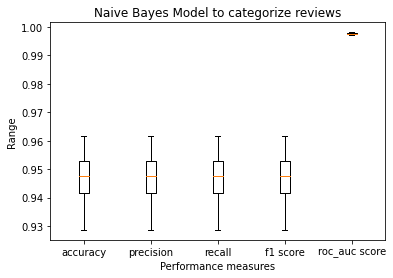

In [35]:
import matplotlib.pyplot as plt
s = [a_list, p_list, r_list, f_list, ro_list]
l = ['accuracy', 'precision', 'recall', 'f1 score', 'roc_auc score']
fig,ax = plt.subplots()
for i,lst in enumerate(s): 
    ax.boxplot(lst,positions=[i])
ax.set_xticklabels(l)
ax.set_title('Naive Bayes Model to categorize reviews')
ax.set_xlabel('Performance measures')
ax.set_ylabel('Range')
plt.show()

Seperating the roc_auc score from the other performance measures in the plot because its range is high.

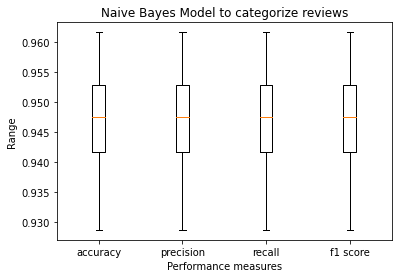

In [36]:
import matplotlib.pyplot as plt
s = [a_list, p_list, r_list, f_list]
l = ['accuracy', 'precision', 'recall', 'f1 score']
fig,ax = plt.subplots()
for i,lst in enumerate(s): 
    ax.boxplot(lst,positions=[i])
ax.set_xticklabels(l)
ax.set_title('Naive Bayes Model to categorize reviews')
ax.set_xlabel('Performance measures')
ax.set_ylabel('Range')
plt.show()

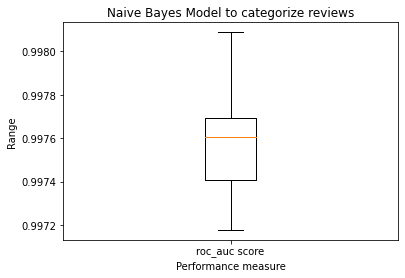

In [37]:
import matplotlib.pyplot as plt
s = [ro_list]
l = ['roc_auc score']
fig,ax = plt.subplots()
for i,lst in enumerate(s): 
    ax.boxplot(lst,positions=[i])
ax.set_xticklabels(l)
ax.set_title('Naive Bayes Model to categorize reviews')
ax.set_xlabel('Performance measure')
ax.set_ylabel('Range')
plt.show()

### Results of Random Forest model

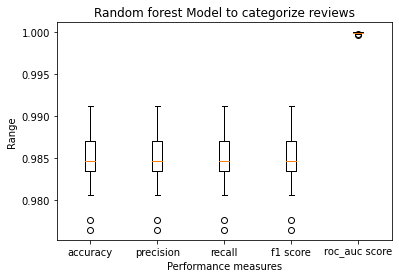

In [38]:
import matplotlib.pyplot as plt
s = [a_list_r, p_list_r, r_list_r, f_list_r, ro_list_r]
l = ['accuracy', 'precision', 'recall', 'f1 score', 'roc_auc score']
fig,ax = plt.subplots()
for i,lst in enumerate(s): 
    ax.boxplot(lst,positions=[i])
ax.set_xticklabels(l)
ax.set_title('Random forest Model to categorize reviews')
ax.set_xlabel('Performance measures')
ax.set_ylabel('Range')
plt.show()

Seperating the roc_auc score from the other performance measures in the plot because its range is high.

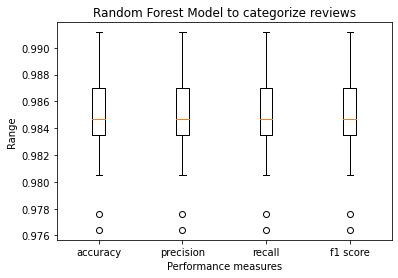

In [39]:
import matplotlib.pyplot as plt
s = [a_list_r, p_list_r, r_list_r, f_list_r]
l = ['accuracy', 'precision', 'recall', 'f1 score']
fig,ax = plt.subplots()
for i,lst in enumerate(s): 
    ax.boxplot(lst,positions=[i])
ax.set_xticklabels(l)
ax.set_title('Random Forest Model to categorize reviews')
ax.set_xlabel('Performance measures')
ax.set_ylabel('Range')
plt.show()

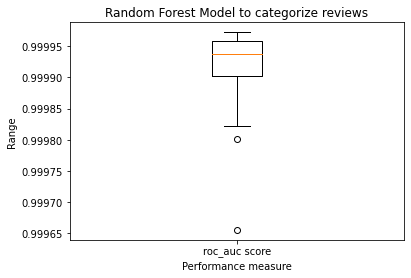

In [54]:
import matplotlib.pyplot as plt
s = [ro_list_r]
l = ['roc_auc score']
fig,ax = plt.subplots()
for i,lst in enumerate(s): 
    ax.boxplot(lst,positions=[i])
ax.set_xticklabels(l)
ax.set_title('Random Forest Model to categorize reviews')
ax.set_xlabel('Performance measure')
ax.set_ylabel('Range')
plt.show()

### Naive Bayes vs Random Forest results.

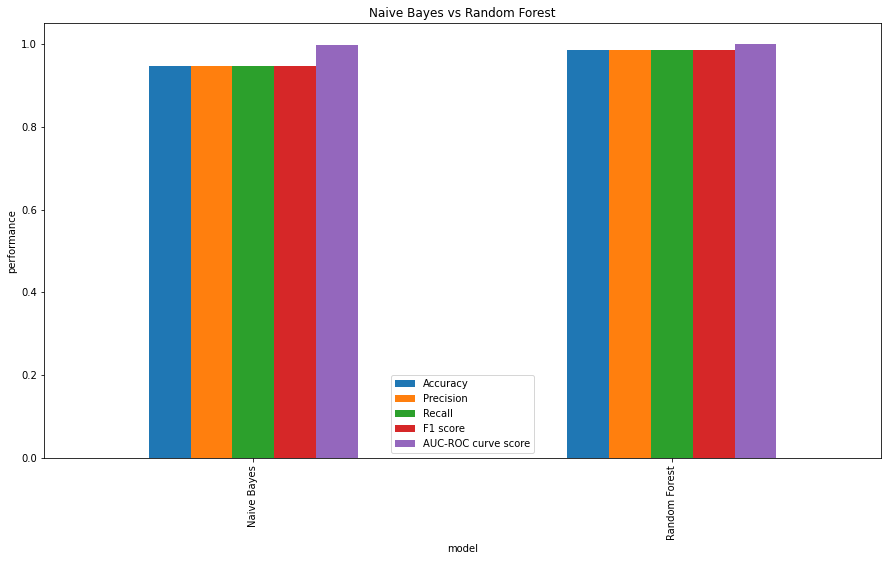

In [41]:
import pandas as pd

plotdata = pd.DataFrame({

    "Accuracy":[acc1, acc2],

    "Precision":[p1, p2],

    "Recall":[r1, r2],

    "F1 score": [f1, f2],
    
    "AUC-ROC curve score": [roc_auc_1, roc_auc_2]},

    index = ["Naive Bayes", "Random Forest"])

plotdata.plot(kind="bar",figsize=(15, 8))

plt.title("Naive Bayes vs Random Forest")

plt.xlabel("model")

plt.ylabel("performance")

plt.show()

## 6- Identifying the relation between words in one review

In [42]:
# Importing necessary libraries
import networkx as nx
import re
import string

In [43]:
# Importing the dataset again
df = pd.read_csv("reviews.csv", encoding= 'utf-8')
df.head(5)

,Text,Class
0,المكان كتيير حلو اكله الحمدلله منيح عادي وفي ا...,1
1,المطعم زرته ﻷول مرة مبارح على بوفيه الفطور الر...,1
2,سناكاته زاكية سعره سعر السوق ..احلى ما في المو...,1
3,"بهارات البروستد كتير مميزة ومش ناقصها اشي , وا...",1
4,هاد الفرع مش تابع لشاورما الريم الاصلي فروع شا...,0


In [44]:
# Defining a review sentence
sentence = df['Text'][0]
sentence

'المكان كتيير حلو اكله الحمدلله منيح عادي وفي اشيا ما كانت طيبه '

In [45]:
# Cleaning the text without stemming
# Applying the cleaning function created earlier on the text
sentence = clean_feedback(df['Text'][0])
sentence = sentence.strip()
sentence

'المكان كتير حلو اكله الحمدله منيح عادي وفي اشيا ما كانت طيبه'

In [46]:
# Splitting the sentence into words
sentence = sentence.split(" ")
sentence

['المكان',
 'كتير',
 'حلو',
 'اكله',
 'الحمدله',
 'منيح',
 'عادي',
 'وفي',
 'اشيا',
 'ما',
 'كانت',
 'طيبه']

In [47]:
pip install arabic-reshaper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
pip install python-bidi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
import arabic_reshaper
import networkx as nx
# Arabic text preprocessing 
l = []
for word in sentence:
  reshaped_text = arabic_reshaper.reshape(word)
  artext = get_display(reshaped_text)
  l.append(artext)

In [50]:
# Creating an empty graph
G = nx.Graph()

In [51]:
# Adding nodes to the graph
for word in l:
    G.add_node(word)

In [52]:
# Adding edges between words
for i in range(len(l) - 1):
    G.add_edge(l[i], l[i+1])

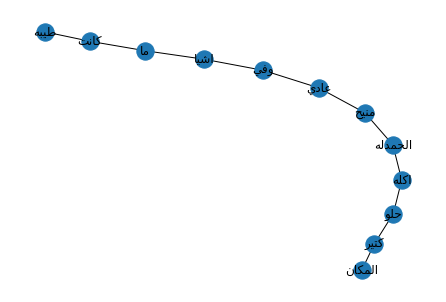

In [53]:
# Drawing the graph
nx.draw(G, with_labels=True)

# References

1- https://www.analyticsvidhya.com/blog/2021/08/understanding-bar-plots-in-python-beginners-guide-to-data-visualization/

2- https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics